In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, norm

In [108]:
dataA = pd.read_csv("RDW.csv").drop(columns=["ID"])      
dataB = pd.read_csv("JS.csv").drop(columns=["ID"]) 

# print(dataA.head())
# print(dataB.head())

In [109]:
sus = pd.read_csv("SUS.csv") 

sus_dataA = sus[sus["ID"].str.startswith("A")].drop(columns=["ID"])
sus_dataB = sus[sus["ID"].str.startswith("B")].drop(columns=["ID"])

# print("RDW:\n", sus_dataA)
# print("JS:\n", sus_dataB)

In [110]:
dataA["Score_SUS"] = sus_dataA["Score_SUS"].values
dataB["Score_SUS"] = sus_dataB["Score_SUS"].values

In [111]:
results = []

In [112]:
for col in dataA.columns:  
    groupA = dataA[col]
    groupB = dataB[col]
    
    # Mann-Whitney U test
    U, p = mannwhitneyu(groupA, groupB, alternative='two-sided')
    
    # Calculer Z value
    n1 = len(groupA)
    n2 = len(groupB)
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    Z = (U - mean_U) / std_U
    
    # Effect size r
    r = Z / np.sqrt(n1 + n2)
    
    # Enregistrer les résultats
    results.append({
        "Question": col,
        "U": U,
        "p-value": p,
        "Median_A": groupA.median(),
        "IQR_A": groupA.quantile(0.75) - groupA.quantile(0.25),
        "Mean_A": groupA.mean(),
        "Median_B": groupB.median(),
        "IQR_B": groupB.quantile(0.75) - groupB.quantile(0.25),
        "Mean_B": groupB.mean(),
        "r": r
    })


In [113]:
results_df = pd.DataFrame(results)
results_df["r"] = results_df["r"].round(3)  

print(results_df)

             Question     U   p-value  Median_A  IQR_A  Mean_A  Median_B  \
0       CTRL_Gestures   7.5  0.287726       4.0    2.0     3.2       4.0   
1           CTRL_Move   8.5  0.402784       4.0    1.0     3.6       4.0   
2     CTRL_Effortless  14.0  0.822456       4.0    0.0     3.8       4.0   
3       CTRL_Coherent  10.0  0.653594       4.0    0.0     3.6       4.0   
4   CTRL_Natural_Walk   3.5  0.062567       3.0    1.0     2.8       4.0   
5          PRE_Events  11.5  0.912771       5.0    2.0     5.0       5.0   
6        PRE_Reactive   8.5  0.406483       6.0    0.0     5.8       6.0   
7          PRE_Engage  14.5  0.733730       6.0    0.0     6.0       6.0   
8         PRE_Natural   5.0  0.131379       3.0    1.0     3.0       4.0   
9       PRE_Realistic  14.0  0.826581       6.0    2.0     5.8       5.0   
10        PRE_Predict   5.0  0.136333       4.0    3.0     4.2       6.0   
11        PRE_Explore   7.0  0.278076       5.0    1.0     5.2       6.0   
12          

In [132]:
def v_boxplot(data_rdw, data_js, cols, fig_title="Boxplot", figsize=(18,6), rot=0, width=0.9):
    
    n = len(cols)
    
    # Chaque question comprend 2 positions: RDW et JS
    positions = []
    for i in range(n):
        positions.append(i*3 + 1)  # RDW
        positions.append(i*3 + 2)  # JS

    # Données pour boxplot
    all_data = []
    means = []
    for col in cols:
        a = data_rdw[col].dropna().values
        b = data_js[col].dropna().values
        all_data.append(a)
        all_data.append(b)
        
        # Calcul des moyennes
        means.append(np.nanmean(a) if a.size>0 else np.nan)
        means.append(np.nanmean(b) if b.size>0 else np.nan)

    plt.figure(figsize=figsize)
    bplots = plt.boxplot(all_data, positions=positions, widths=width, patch_artist=True)
    
    # Coloration des boxplots
    colors = ['skyblue', 'salmon'] * n  # RDW=skyblue, JS=salmon
    for patch, color in zip(bplots['boxes'], colors):
        patch.set_facecolor(color)
    
    for i, median in enumerate(bplots['medians']):
        median.set_color('black')
        median.set_linewidth(3)
        
    for pos, mv, col_idx in zip(positions, means, range(len(means))):
        if np.isnan(mv):
            continue
        color = colors[col_idx]  # match box color
        plt.scatter(pos, mv, marker='D', s=80, color=color, edgecolor='black', zorder=10)
    
    plt.legend([bplots["boxes"][0], bplots["boxes"][1]], ['RDW', 'Joystick'], loc='upper right')
    
    plt.xticks([i*3 + 1.5 for i in range(n)], cols, rotation=rot)
    plt.ylabel("Score")
    plt.title(fig_title)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [133]:
# Separer les colonnes PRE et les autres
dataA = dataA.iloc[:, :-1]
dataB = dataB.iloc[:, :-1]


pre_cols = [
    "PRE_Events",
    "PRE_Reactive",
    "PRE_Engage",
    "PRE_Natural",
    "PRE_Realistic",
    "PRE_Predict",
    "PRE_Explore",
    "PRE_Delay"
]

ctrl_cols = [
    "CTRL_Gestures",
    "CTRL_Move",
    "CTRL_Effortless",
    "CTRL_Coherent",
    "CTRL_Natural_Walk"
]

cs_cols = [col for col in dataA.columns if col not in pre_cols + ctrl_cols]

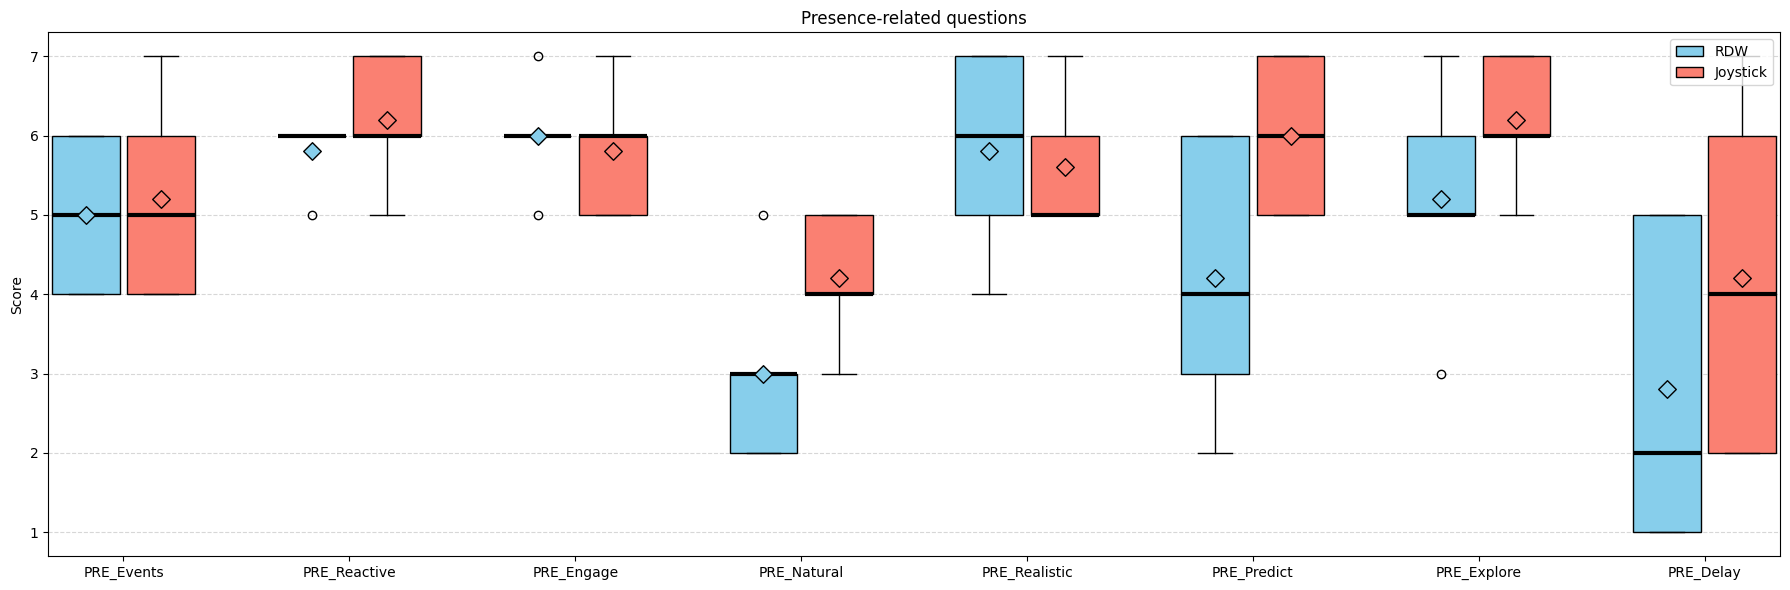

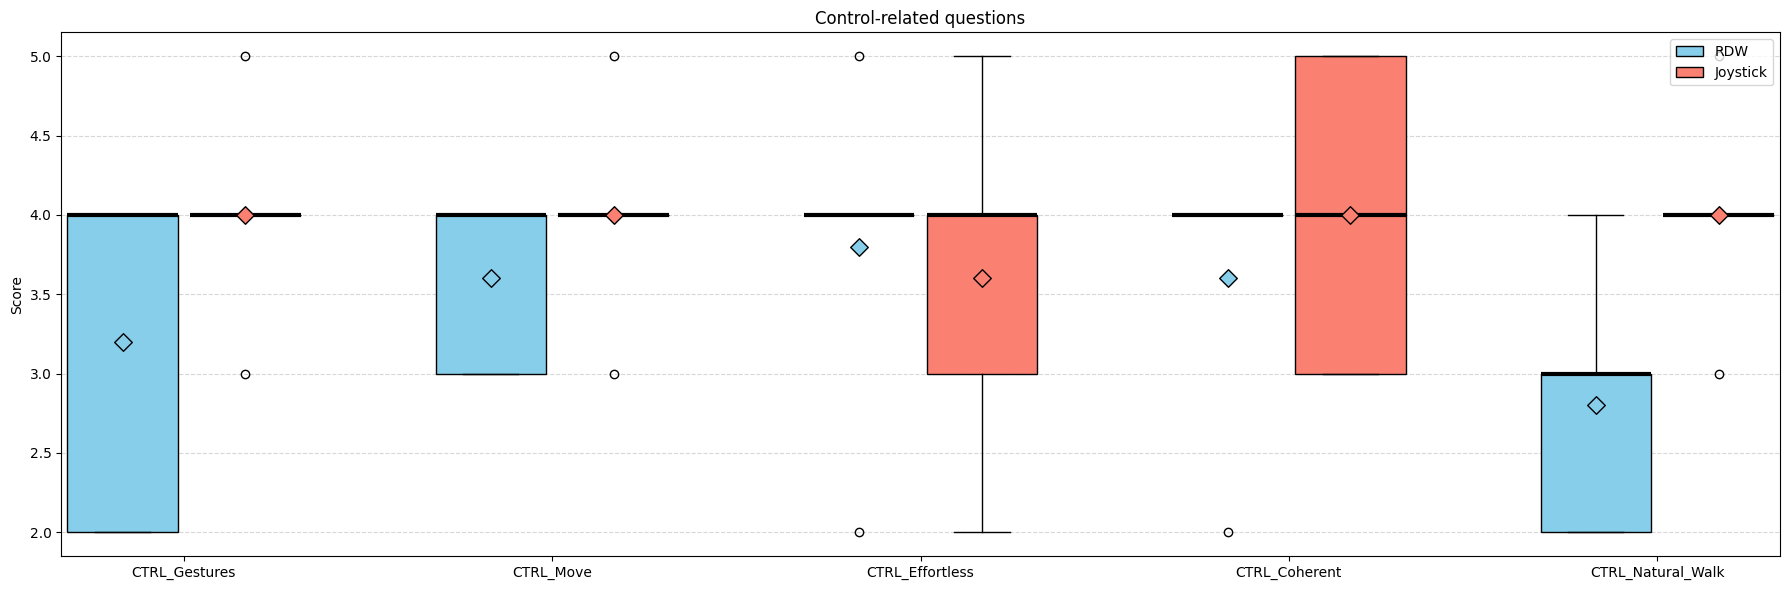

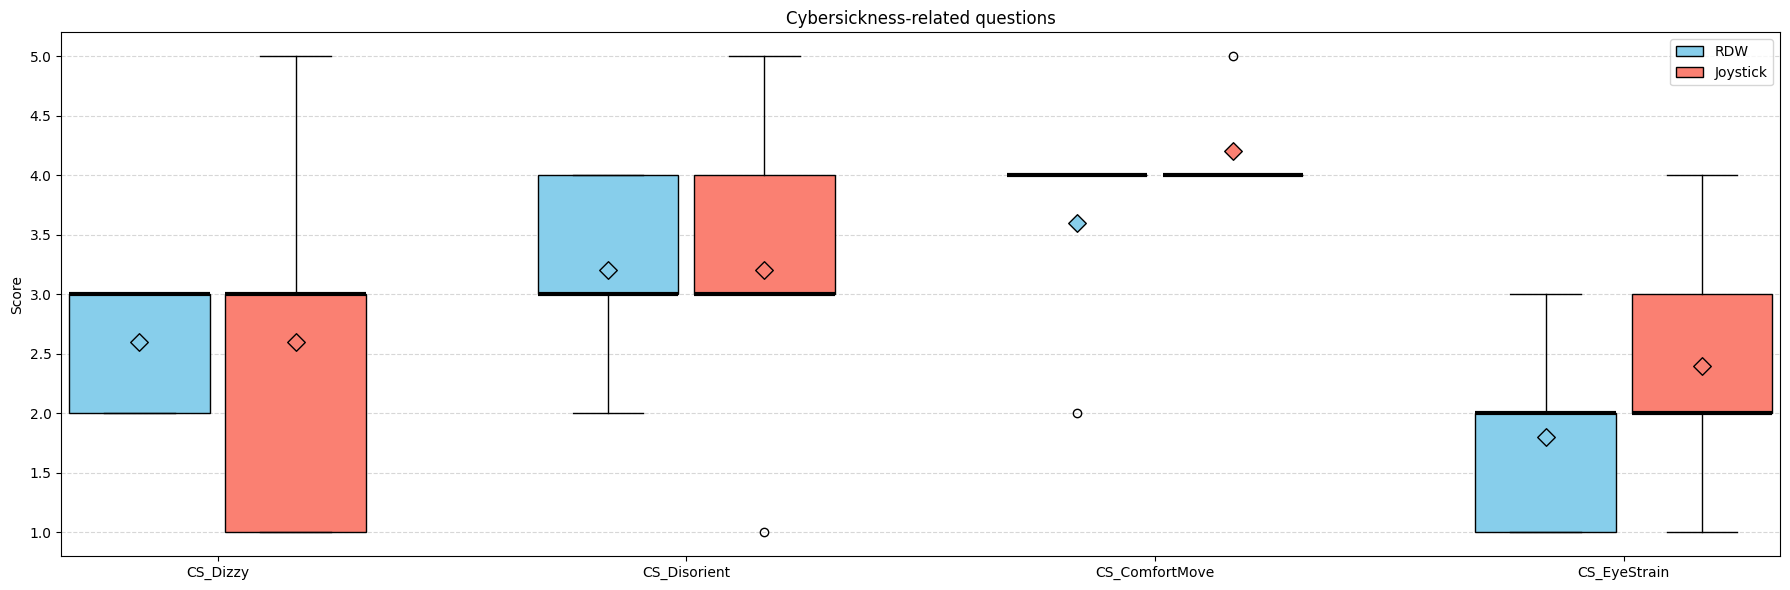

In [134]:
# Image 1: Questions liées à la présence (PRE)
v_boxplot(
    dataA,
    dataB,
    pre_cols,
    fig_title="Presence-related questions",
)

# Image 2: Questions de contrôle 
v_boxplot(
    dataA,
    dataB,
    ctrl_cols,
    fig_title="Control-related questions",
)

# Image 3: Questions de cybersickness
v_boxplot(
    dataA,
    dataB,
    cs_cols,
    fig_title="Cybersickness-related questions",
)

In [117]:
# desc_a = descriptives(sus_dataA)
# desc_b = descriptives(sus_dataB)
# print("RDW:", desc_a)
# print("JS:", desc_b)
print("Shapiro RDW - pvalue:", shapiro(sus_dataA).pvalue)
print("Shapiro JS - pvalue:", shapiro(sus_dataB).pvalue)




Shapiro RDW - pvalue: 0.13738199588019467
Shapiro JS - pvalue: 0.13274905085447297


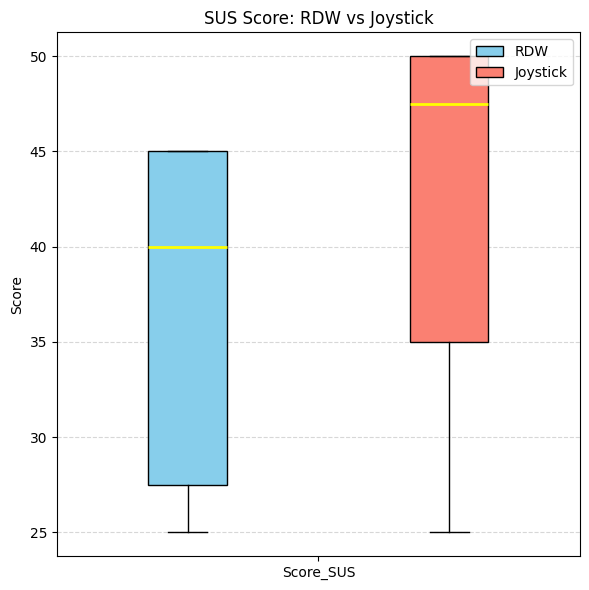

In [118]:
v_boxplot(
    sus_dataA,
    sus_dataB,
    cols=["Score_SUS"], 
    fig_title="SUS Score: RDW vs Joystick",
    figsize=(6,6),
    rot=0,
    width=0.3
)

In [119]:
cols = dataA.columns.tolist()

rows = []
alpha = 0.05  # ngưỡng quyết định

dataA["Score_SUS"] = sus_dataA["Score_SUS"].values
dataB["Score_SUS"] = sus_dataB["Score_SUS"].values

for col in cols:
    # Lấy dữ liệu (loại NaN nếu có)
    a = dataA[col].dropna().values
    b = dataB[col].dropna().values
    
    # Nếu kích thước quá nhỏ thì Shapiro có thể không đáng tin (but still computable for n>=3)
    if len(a) < 3:
        stat_a, p_a = np.nan, np.nan
        note_a = "n<3"
    else:
        stat_a, p_a = shapiro(a)
        note_a = "Normal" if p_a >= alpha else "Not normal"
    
    if len(b) < 3:
        stat_b, p_b = np.nan, np.nan
        note_b = "n<3"
    else:
        stat_b, p_b = shapiro(b)
        note_b = "Normal" if p_b >= alpha else "Not normal"

    rows.append({
        "Variable": col,
        "n_A": len(a),
        "Shapiro_stat_A": round(stat_a, 4) if not np.isnan(stat_a) else "",
        "p_A": round(p_a, 4) if not np.isnan(p_a) else "",
        "Normal_A?": note_a,
        "n_B": len(b),
        "Shapiro_stat_B": round(stat_b, 4) if not np.isnan(stat_b) else "",
        "p_B": round(p_b, 4) if not np.isnan(p_b) else "",
        "Normal_B?": note_b
    })

shapiro_df = pd.DataFrame(rows)
# Sắp xếp cho dễ nhìn (ví dụ theo p_A nhỏ -> lớn)
shapiro_df = shapiro_df.sort_values(by=["p_A","p_B"], na_position="last").reset_index(drop=True)

# Hiển thị bảng
shapiro_df


,Variable,n_A,Shapiro_stat_A,p_A,Normal_A?,n_B,Shapiro_stat_B,p_B,Normal_B?
0,CS_ComfortMove,5,0.5522,0.0001,Not normal,5,0.5522,0.0001,Not normal
1,CTRL_Coherent,5,0.5522,0.0001,Not normal,5,0.8208,0.1185,Normal
2,PRE_Reactive,5,0.5522,0.0001,Not normal,5,0.8810,0.3140,Normal
3,CS_Dizzy,5,0.6840,0.0065,Not normal,5,0.8810,0.3140,Normal
4,CTRL_Gestures,5,0.6840,0.0065,Not normal,5,0.8835,0.3254,Normal
5,CTRL_Move,5,0.6840,0.0065,Not normal,5,0.8835,0.3254,Normal
6,PRE_Delay,5,0.7817,0.0571,Normal,5,0.8843,0.3290,Normal
7,PRE_Events,5,0.8208,0.1185,Normal,5,0.9020,0.4211,Normal
8,CTRL_Effortless,5,0.8283,0.1350,Normal,5,0.9609,0.8140,Normal
9,PRE_Natural,5,0.8327,0.1458,Normal,5,0.8810,0.3140,Normal
